In [1]:
from invisible_cities.cities.components import wf_from_files, WfType
from invisible_cities.cities.components import deconv_pmt, calibrate_pmts, get_pmt_wfs, load_dst
from invisible_cities.io.pmaps_io import load_pmaps
from invisible_cities.io.pmaps_io import load_pmaps_as_df
import pandas as pd
import numpy as np
import tables as tb
import os
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from mpl_interactions import ioff, panhandler, zoom_factory
import glob
from matplotlib.colors import LogNorm

In [2]:
# Load in the pmaps from the data

pmaps_data = load_pmaps_as_df("../data/run_13852_0000_ldc1_trg0_irene.h5")

s1_pmaps_data = pmaps_data[0]
s2_pmaps_data = pmaps_data[1]

# want event 37
display(s1_pmaps_data)
print(s1_pmaps_data.event.unique())

,event,peak,time,bwidth,ene
0,9,0,1925.0,25.0,0.364390
1,9,0,1950.0,25.0,0.638245
2,9,0,1975.0,25.0,0.906407
3,9,0,2000.0,25.0,0.763632
4,9,0,2025.0,25.0,0.396182
...,...,...,...,...,...
25245,597,0,216500.0,25.0,0.430239
25246,597,0,216525.0,25.0,0.662060
25247,597,0,216550.0,25.0,0.525257
25248,597,0,216575.0,25.0,0.622339


[  9  37  58  65  72  79  86 100 121 149 156 170 177 205 212 219 247 261
 268 275 282 296 310 324 338 345 366 408 415 422 436 450 485 492 506 513
 534 541 555 562 569 576 583 590 597]


9
37
58
65
72
79
86


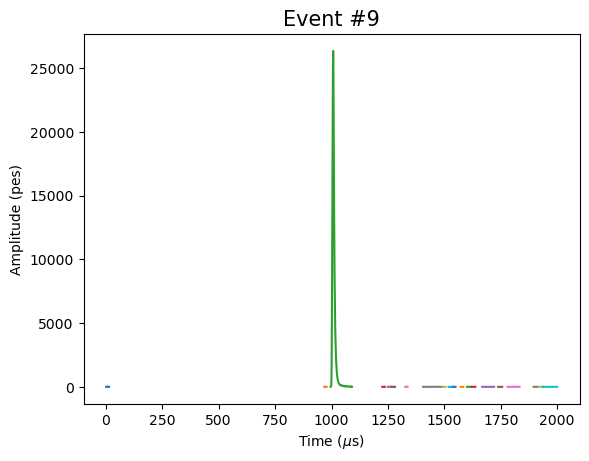

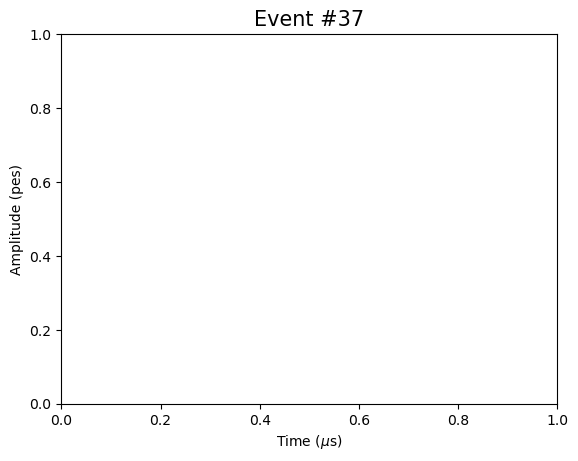

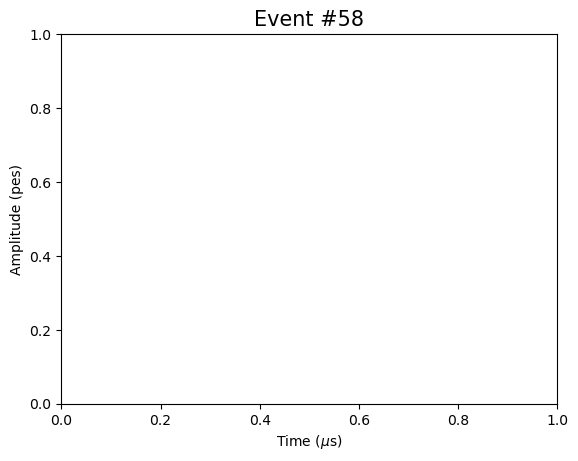

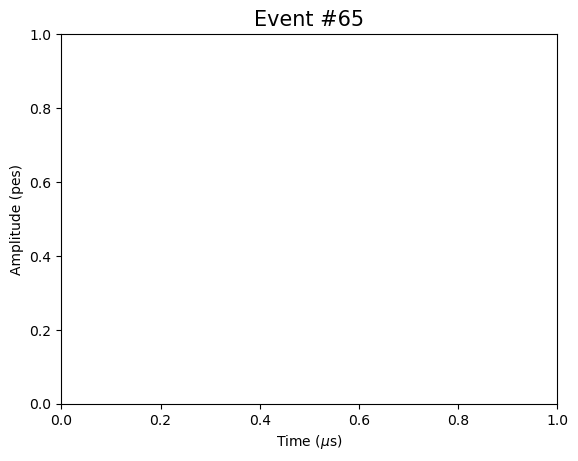

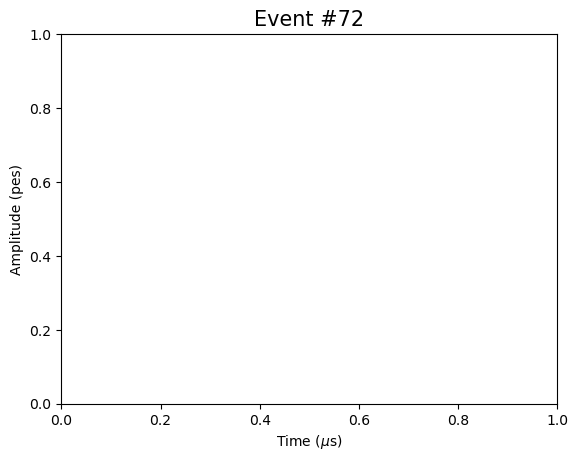

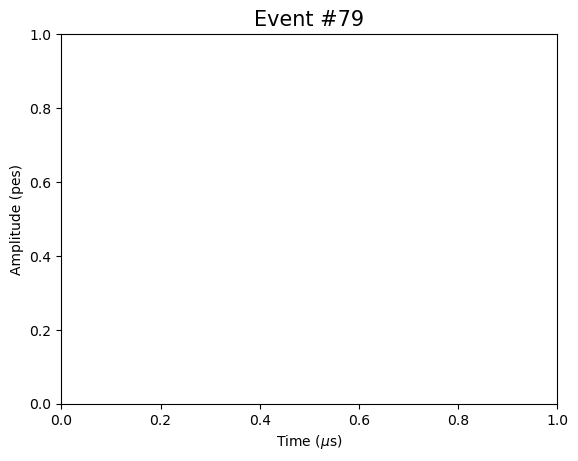

In [10]:
%matplotlib inline
s1s_data, s2s_data, s2sis, s1pmts, s2pmts = pmaps_data

for index, eventid in enumerate(s1s_data.event.unique()):
    print(eventid)

    if index > 5: break

    # eventid = 100

    s1s_data   = s1s_data  .loc[lambda df: df.event == eventid]
    s2s_data   = s2s_data  .loc[lambda df: df.event == eventid]
    # s2sis = s2sis.loc[lambda df: df.event == eventid]

    plt.figure()

    for _, s1 in s1s_data.groupby("peak"):
        plt.plot(s1.time / 1e3, s1.ene) # plot the PMT-summed waveform slice


    for _, s2 in s2s_data.groupby("peak"):
        plt.plot(s2.time / 1e3, s2.ene) # plot the PMT-summed waveform slice


    plt.xlabel("Time ($\mu$s)")
    plt.ylabel("Amplitude (pes)")
    plt.title(f"Event #{eventid}", fontsize=15);
    plt.savefig(f"../plots/pmaps/{eventid}.png")